## 감성분석(Sentiment Analysis)

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
# Naver Sentiment Movie Corpus v1.0 다운로드
path_to_train_file = tf.keras.utils.get_file('train.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
path_to_test_file = tf.keras.utils.get_file('test.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

In [3]:
# 데이터를 메모리에 불러옵니다. encoding 형식으로 utf-8 을 지정해야합니다.
train_text = open(path_to_train_file, 'rb').read().decode(encoding='utf-8')
test_text = open(path_to_test_file, 'rb').read().decode(encoding='utf-8')
print('train text length:',len(train_text),' characters')
print('test  text length:',len(test_text),' characters')
print('\n')
print(train_text[:5])
print(train_text[:300])

train text length: 6937271  characters
test  text length: 2318260  characters


id	do
id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의


In [4]:
# import pandas as pd
# df_train = pd.read_csv(path_to_train_file,sep='\t')
# df_train

In [5]:
# 각 문장을 '\n'으로 분리 -> 헤더제외 -> '\t'으로 분리 -> 마지막 문자 정수로 변환하여 2차원으로 변환
train_Y = np.array([[int(row.split('\t')[2])] for row in train_text.split('\n')[1:] if row.count('\t') > 0])
test_Y = np.array([[int(row.split('\t')[2])] for row in test_text.split('\n')[1:] if row.count('\t') > 0])
print(train_Y.shape, test_Y.shape)  # (150000, 1) (50000, 1)
print(train_Y[:5])

(150000, 1) (50000, 1)
[[0]
 [1]
 [0]
 [0]
 [1]]


In [6]:
# X 값을 추출
train_text_X = [row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t') > 0]
print(len(train_text_X))
train_text_X[:5]

150000


['아 더빙.. 진짜 짜증나네요 목소리',
 '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나',
 '너무재밓었다그래서보는것을추천한다',
 '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정',
 '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다']

### 텍스트 전처리

In [7]:
# train 데이터의 입력(X)에 대한 정제(Cleaning)
import re
# From https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
def clean_str(string):    
    string = re.sub(r"[^가-힝A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\'{2,}", "\'", string)
    string = re.sub(r"\'", "", string)

    return string.lower()

train_text_X =[clean_str(sentence) for sentence in train_text_X ]
# train_text_X[:5]

# 문장을 띄어쓰기 단위로 단어 분리
sentences = [sentence.split(' ') for sentence in train_text_X]
sentences[:5]

[['아', '더빙', '진짜', '짜증나네요', '목소리'],
 ['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나'],
 ['너무재밓었다그래서보는것을추천한다'],
 ['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정'],
 ['사이몬페그의',
  '익살스런',
  '연기가',
  '돋보였던',
  '영화',
  '!',
  '스파이더맨에서',
  '늙어보이기만',
  '했던',
  '커스틴',
  '던스트가',
  '너무나도',
  '이뻐보였다']]

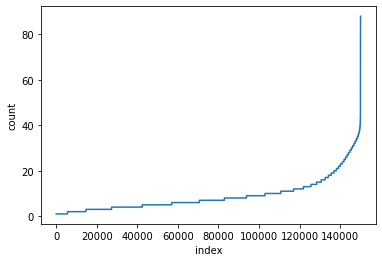

142587


In [8]:
# 150000개 문장의 단어 길이 확인
import matplotlib.pyplot as plt
sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()
plt.plot(sentence_len)
plt.xlabel('index')
plt.ylabel('count')
plt.show()

print(sum([int(l<=25) for l in sentence_len]))
# 15 만개 문장 중 단어 갯수가 25개 이하인 문장의 수가 142590개이다, 25를 sequence_length로 사용

In [9]:
# 단어 정제 및 문장 길이 줄임
# 문장의 최대 길이를 25로 잡고 그 이상은 잘라내고 단어의 앞에서 5글자씩만 잘라서 사용한다
sentences_new = []
for sentence in sentences:
    sentences_new.append([word[:5] for word in sentence[:25]])
sentences = sentences_new
sentences[:5]

[['아', '더빙', '진짜', '짜증나네요', '목소리'],
 ['흠', '포스터보고', '초딩영화줄', '오버연기조', '가볍지', '않구나'],
 ['너무재밓었'],
 ['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정'],
 ['사이몬페그',
  '익살스런',
  '연기가',
  '돋보였던',
  '영화',
  '!',
  '스파이더맨',
  '늙어보이기',
  '했던',
  '커스틴',
  '던스트가',
  '너무나도',
  '이뻐보였다']]

In [10]:
#  Tokenizer와 pad_sequences를 사용한 문장 전처리
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=20000) # 빈도수가 높은 20000개 단어만 사용하여 숫자로 반환하고 나머지는 공백으로 반환
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)  # 인덱스를 반환
train_X = pad_sequences(sequences,padding='post')   # 문장의 뒤부분으로 0을 패딩한다, 공백도 0으로 채워진다

train_X[:5]  # 25개의 길이로 패딩 완성

array([[   25,   884,     8,  5795,  1111,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [  588,  5796,  6697,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [   71,   346,    31,    35, 10468,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [  106,  5338,     4,     2,  2169,   869,   573,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0]])

In [11]:
# Tokenizer의 동작 확인
print(tokenizer.index_word[19999])
print(tokenizer.index_word[20000])
temp = tokenizer.texts_to_sequences(['#$#$#', '경우는', '잊혀질', '연기가']) # 빈도가 낮은 '잊혀질'은 공백으로 반환
print(temp)
temp = pad_sequences(temp, padding='post')
print(temp)  # 최대길이가 1이므로 1보다 작은 문장은 0이 패딩된다

경우는
잊혀질
[[], [19999], [], [106]]
[[    0]
 [19999]
 [    0]
 [  106]]


### 학습 모델 구현

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(20000,300,input_length=25),
    tf.keras.layers.LSTM(units=50),
    tf.keras.layers.Dense(2,activation='softmax')
])

# sparse_categorical_crossentropy : 정답 Y가 희소인 다중 분류 모델의 loss
# categorical_crossentropy: 다중 분류 모델의 loss

# loss 종류
# mean_squared_error : 평균제곱 오차
# binary_crossentropy : 이진분류 오차
# categorical_crossentropy : 다중 분류 오차. one-hot encoding 클래스, [0.2, 0.3, 0.5] 와 같은 출력값과 실측값의 오차값을 계산한다.
# sparse_categorical_crossentropy: 다중 분류 오차. 위와 동일하지만 , integer type 클래스라는 것이 다르다.

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 300)           6000000   
_________________________________________________________________
lstm (LSTM)                  (None, 50)                70200     
_________________________________________________________________
dense (Dense)                (None, 2)                 102       
Total params: 6,070,302
Trainable params: 6,070,302
Non-trainable params: 0
_________________________________________________________________


In [13]:
# 감성 분석 모델 학습 : 약 7분 소요
history = model.fit(train_X, train_Y, epochs=5, batch_size=128, validation_split=0.2)

Train on 120000 samples, validate on 30000 samples
Epoch 1/5
120000/120000 [==============================] - 189s 2ms/sample - loss: 0.4357 - accuracy: 0.7833 - val_loss: 0.3809 - val_accuracy: 0.8183
Epoch 2/5
120000/120000 [==============================] - 225s 2ms/sample - loss: 0.3230 - accuracy: 0.8471 - val_loss: 0.3882 - val_accuracy: 0.8188
Epoch 3/5
120000/120000 [==============================] - 218s 2ms/sample - loss: 0.2698 - accuracy: 0.8696 - val_loss: 0.4283 - val_accuracy: 0.8192
Epoch 4/5
120000/120000 [==============================] - 223s 2ms/sample - loss: 0.2256 - accuracy: 0.8905 - val_loss: 0.4711 - val_accuracy: 0.8092
Epoch 5/5
120000/120000 [==============================] - 221s 2ms/sample - loss: 0.1914 - accuracy: 0.9064 - val_loss: 0.5301 - val_accuracy: 0.8053


In [20]:
history.history['loss']
history.history['val_loss']
history.history['accuracy']
history.history['val_accuracy']

[0.8183, 0.8188, 0.81923336, 0.80916667, 0.8052667]

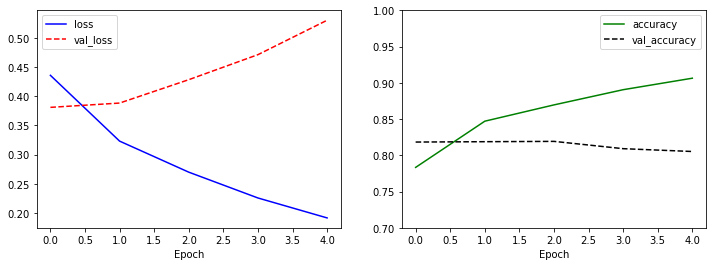

In [21]:
# 감성 분석 모델 학습 결과 확인
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

In [27]:
## 정확도 측정
test_text_X = [row.split('\t')[1] for row in test_text.split('\n')[1:] if row.count('\t') > 0]
test_text_X = [clean_str(sentence) for sentence in test_text_X ]

# 문장을 띄어쓰기 단위로 단어 분리
sentences = [sentence.split(' ') for sentence in test_text_X]

# 문장의 최대 길이를 25로 잡고 그 이상은 잘라내고 단어의 앞에서 5글자씩만 잘라서 사용한다
sentences_new = []
for sentence in sentences:
    sentences_new.append([word[:5] for word in sentence[:25]])
sentences = sentences_new

sequences = tokenizer.texts_to_sequences(sentences) # 인덱스를 반환
test_X = pad_sequences(sequences,padding='post')   # 문장의 뒤부분으로 0을 패딩한다, 공백도 0으로 채워진다

test_X[:5]  # 25개의 길이로 패딩 완성

array([[  594,     1,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [  357,     9,  4626,   990,    69,  3348,  2773,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [ 2110,    32, 12562,   506,  1450,     1,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [17857,   109, 12074,   244, 18890,    11,  3365,   348,   468,
        12715,     5,     5,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0]])

In [28]:
accr = model.evaluate(test_X,test_Y,verbose=0)

In [29]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.539
  Accuracy: 0.797


### 예측

In [37]:
# 임의의 문장 감성 분석 예측 결과 확인
test_sentence = '재미있을 줄 알았는데 완전 실망했다. 너무 졸리고 돈이 아까웠다.'
test_sentence = test_sentence.split(' ') # ['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고', '돈이', '아까웠다.']
test_sentences = []
now_sentence = []

for word in test_sentence:
    now_sentence.append(word)
    test_sentences.append(now_sentence[:])
    
# test_sentences  # 9개

sequences = tokenizer.texts_to_sequences(test_sentences) 
test_X_1 = pad_sequences(sequences,padding='post',maxlen=25) 
# test_X_1

prediction = model.predict(test_X_1)  # 분류할 값 2개가 확률로 출력

for idx, sentence in enumerate(test_sentences):
    print(sentence)
    print(prediction[idx])

['재미있을']
[0.40482658 0.5951734 ]
['재미있을', '줄']
[0.398328 0.601672]
['재미있을', '줄', '알았는데']
[0.5118013 0.4881986]
['재미있을', '줄', '알았는데', '완전']
[0.42571113 0.57428885]
['재미있을', '줄', '알았는데', '완전', '실망했다.']
[0.42571113 0.57428885]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무']
[0.40470037 0.5952996 ]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고']
[0.98068386 0.01931615]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고', '돈이']
[0.99827397 0.00172599]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고', '돈이', '아까웠다.']
[0.99827397 0.00172599]


In [39]:
# 감성 분석 함수 구현
def sentiment_predict(test_sentence):
    test_sentence = test_sentence.split(' ')
    test_sentences = []
    now_sentence = []

    for word in test_sentence:
        now_sentence.append(word)
        test_sentences.append(now_sentence[:])

    sequences = tokenizer.texts_to_sequences(test_sentences) 
    test_X_1 = pad_sequences(sequences,padding='post',maxlen=25) 

    prediction = model.predict(test_X_1)  

    for idx, sentence in enumerate(test_sentences):
        score = prediction[idx]
    
    if(score[0] > score[1]):
        print("{:.2f}% 확률로 부정 리뷰입니다.".format(score[0] * 100))
    else:
        print("{:.2f}% 확률로 긍정 리뷰입니다.".format((1 - score[0]) * 100))  

In [40]:
sentiment_predict('이 영화 개꿀잼 ~')

98.55% 확률로 긍정 리뷰입니다.


In [41]:
sentiment_predict('넘 재미없어 내내 졸았어요')

99.87% 확률로 부정 리뷰입니다.


In [44]:
sentiment_predict('돈이 아까워요 ')

99.67% 확률로 부정 리뷰입니다.


In [45]:
sentiment_predict('이 영화 하품만 나와요~')

98.43% 확률로 부정 리뷰입니다.


In [46]:
sentiment_predict('두번 봐도 재미있어요')

99.52% 확률로 긍정 리뷰입니다.


In [47]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

99.36% 확률로 부정 리뷰입니다.


In [48]:
sentiment_predict('이 영화 왜 만든거야')

97.82% 확률로 부정 리뷰입니다.


In [49]:
sentiment_predict('이 영화 꼭 보세요')

76.89% 확률로 긍정 리뷰입니다.


In [51]:
sentiment_predict('안녕하세요')

54.29% 확률로 긍정 리뷰입니다.
